In [ ]:
import nltk
nltk.download('punkt')
nltk.download('all')

In [ ]:
!pip install numpy==1.23.5 scipy==1.9.3 gensim==4.3.1 --force-reinstall --quiet

<ipython-input-1-4a8da0d773fc>:18: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)
<ipython-input-1-4a8da0d773fc>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = pd.to_numeric(df['price'], errors='coerce')
<ipython-input-1-4a8da0d773fc>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)



Model Performance:
| Metric                | Value         |
|-----------------------|---------------|
| MAE                   | $2,529.71     |
| MSE                   | 19,455,028.43 |
| RMSE                  | $4,410.79     |
| R² Score              | 0.84          |
| MAPE                  | 26.53%        |
| Median Absolute Error | $1,137.00     |
| Explained Variance    | 0.84          |


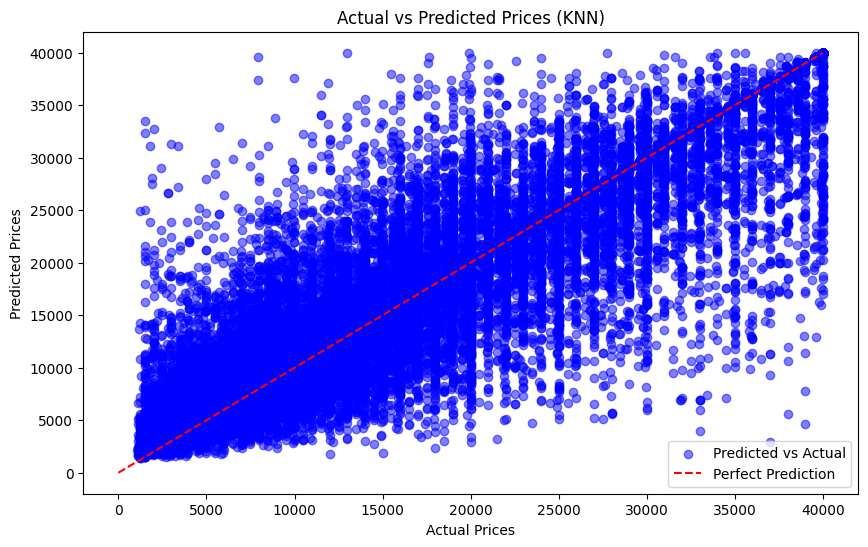

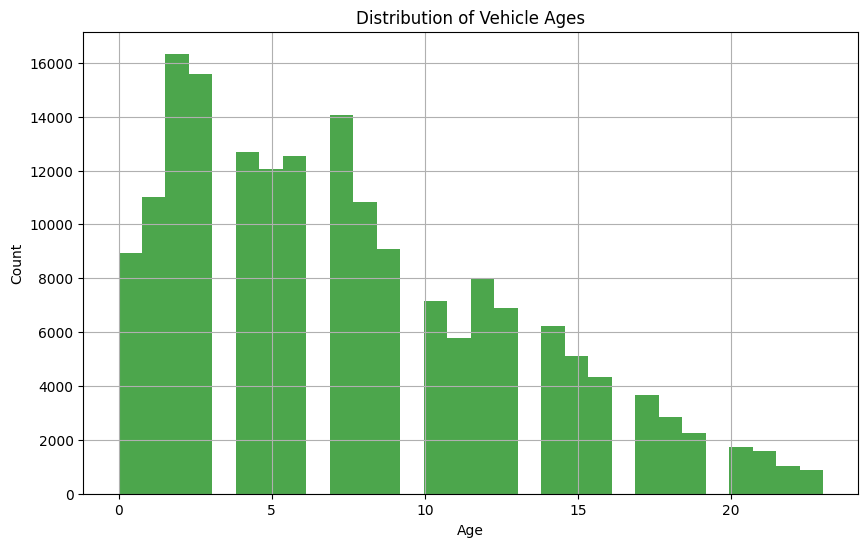

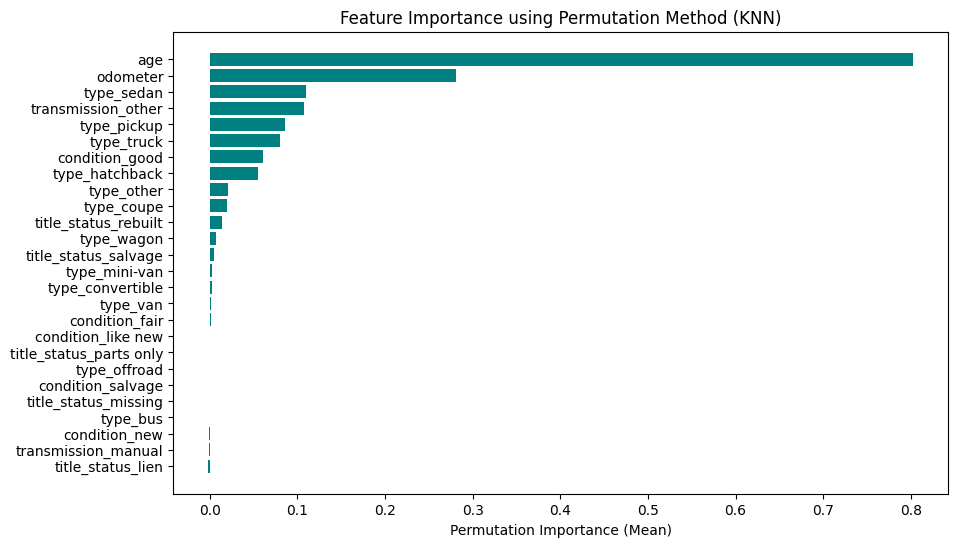

In [ ]:
# KNN Block
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_absolute_error, r2_score, mean_squared_error,
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)
from sklearn.inspection import permutation_importance

# Load dataset from KaggleHub
file_path = "vehicles.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)

# Drop unused columns
unused_cols = ['state','fuel','drive','manufacturer','cylinders','id', 'url', 'region', 'region_url',
               'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date']
df.drop(columns=unused_cols, inplace=True)

# Select relevant and clean data
df = df[['price', 'year', 'condition', 'odometer', 'title_status', 'transmission', 'type']]
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(inplace=True)
df = df[(df['price'] > 1000) & (df['price'] <= 40000)]
df = df[(df['year'] >= 1997) & (df['year'] <= 2020)]

# Add 'age' and one-hot encode categoricals
df['age'] = 2020 - df['year']
df.drop(columns='year', inplace=True)
df = pd.get_dummies(df, columns=['transmission', 'type', 'condition', 'title_status'], drop_first=True)

# Split features and target
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale odometer
scaler = StandardScaler()
X_train[['odometer']] = scaler.fit_transform(X_train[['odometer']])
X_test[['odometer']] = scaler.transform(X_test[['odometer']])

# Train KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_preds = knn_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, knn_preds)
mse = mean_squared_error(y_test, knn_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, knn_preds)
mape = mean_absolute_percentage_error(y_test, knn_preds)
medae = median_absolute_error(y_test, knn_preds)
evs = explained_variance_score(y_test, knn_preds)

# Print Model Performance Table
print("\nModel Performance:")
from tabulate import tabulate
print(tabulate([
    ['MAE', f"${mae:,.2f}"],
    ['MSE', f"{mse:,.2f}"],
    ['RMSE', f"${rmse:,.2f}"],
    ['R² Score', f"{r2:.2f}"],
    ['MAPE', f"{mape * 100:.2f}%"],
    ['Median Absolute Error', f"${medae:,.2f}"],
    ['Explained Variance', f"{evs:.2f}"]
], headers=['Metric', 'Value'], tablefmt='github'))

# Plot: Actual vs Predicted Prices
plt.figure(figsize=(10,6))
plt.scatter(y_test, knn_preds, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (KNN)')
plt.legend()
plt.show()

# Plot: Age distribution
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='green', alpha=0.7)
plt.title("Distribution of Vehicle Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()


# Reduce the number of samples in X_test for faster computation (if you can afford it)
X_test_small = X_test.sample(n=500, random_state=42)  # Sample 500 rows for faster computation
y_test_small = y_test.loc[X_test_small.index]

# Permutation importance (minimal repeats, smaller subset of test data, parallelized)
perm = permutation_importance(
    knn_model, X_test_small, y_test_small,
    n_repeats=1, random_state=30, n_jobs=-1
)

perm_sorted_idx = perm.importances_mean.argsort()

# Plot Permutation Importance
plt.figure(figsize=(10,6))
plt.barh(X.columns[perm_sorted_idx], perm.importances_mean[perm_sorted_idx], color='teal')
plt.xlabel("Permutation Importance (Mean)")
plt.title("Feature Importance using Permutation Method (KNN)")
plt.show()
